In [1]:
import numpy as np
import scipy.stats as ss

In [2]:
LAMBDA = 100
N_OBS = 10
CONFIDENCE = 0.99

TRUE_DIST = ss.poisson(LAMBDA)
OBS = TRUE_DIST.rvs(size=N_OBS)
MAX_OBS = max(OBS)

# choose uniformative priors for the gamma distribution
ALPHA_PRIOR = 1e-3
BETA_PRIOR = 1e-3

In [3]:
OBS

array([105,  90, 102, 113, 114, 103,  92, 101,  77, 121])

## samle from posterior and compare to true distribution

In [4]:
N_POSTERIOR_SAMPLES = 1000

In [5]:
# update priors based on observations
ALPHA_POST = ALPHA_PRIOR + sum(OBS)
BETA_POST = BETA_PRIOR + len(OBS)

In [6]:
lam = ss.gamma.median(ALPHA_POST, scale=1/BETA_POST)
posterior = ss.poisson(lam)

In [7]:
posterior_samples = posterior.rvs(size=N_POSTERIOR_SAMPLES)
true_dist_samples = TRUE_DIST.rvs(size=N_POSTERIOR_SAMPLES)

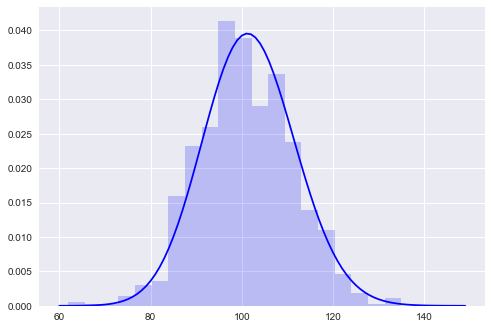

In [20]:
import utils
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.hist(posterior_samples, bins=20, color='b', alpha=0.2, density=True)
utils.plot_dist(posterior, discrete=True, ax=ax)

## get max estimate from cdf

In [9]:
import scipy.stats as ss
def estimate_max(dist, limit):
    return dist.ppf(limit)

In [10]:
MAX_EST = estimate_max(posterior, CONFIDENCE)
MAX_EST

126.0

In [11]:
# how many samples are actually less than our max estimate
sum(x < MAX_EST for x in posterior_samples) / len(posterior_samples)

0.991

In [12]:
# is our estimate bigger than the max?
MAX_EST - MAX_OBS

5.0

# Online learning

In [13]:
class Model:
    def __init__(self, alpha, beta, confidence):
        self.alpha = alpha
        self.beta = beta
        self.confidence = confidence
        
    def predict(self):
        return ss.poisson.ppf(self.confidence, self.lambda_)
        
    def update(self, observation):
        self.alpha += observation
        self.beta += 1
        
    @property
    def lambda_(self):
        return ss.gamma.median(self.alpha, scale=1/self.beta)

In [14]:
TRIAL_LENGTH = 1000
model = Model(ALPHA_POST, BETA_POST, CONFIDENCE)
observations = TRUE_DIST.rvs(size=TRIAL_LENGTH)
predictions = []
for observation in observations:
    model.update(observation)
    predictions.append(model.predict())

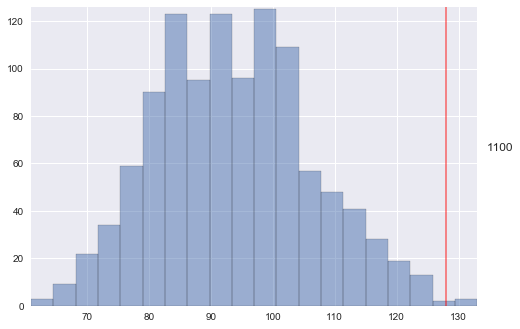

In [21]:
import utils
from IPython.display import HTML
ani = utils.visualize_learning(observations, predictions, bins=20)
HTML(ani.to_html5_video())

# online training with moving distribution

In [16]:
import collections
class Model:
    def __init__(self, alpha, beta, confidence, memory):
        self.alpha = alpha
        self.beta = beta
        self.confidence = confidence
        self.memory = collections.deque(maxlen=memory)
        
    def predict(self):
        return ss.poisson.ppf(self.confidence, self.lambda_)
        
    def update(self, observation):
        self.memory.append(observation)
        self.alpha = sum(self.memory)
        self.beta = len(self.memory)
        
    @property
    def lambda_(self):
        return ss.gamma.median(self.alpha, scale=1/self.beta)

In [27]:
import itertools
model = Model(1e-3, 1e-3, CONFIDENCE, 50)

# create distributions to generate data from
for 
lambdas = list(reversed(range(80, 110, 5)))
lambdas += list(range(85, 110, 5))
true_dists = [ss.poisson(L) for L in lambdas for _ in range(100)]
observations = np.array([d.rvs() for d in true_dists])
predictions = []
model_params = []
for observation in observations:
    model.update(observation)
    model_params.append((
        ss.gamma(model.alpha, scale=1/model.beta),
        ss.poisson(model.lambda_)))
    predictions.append(model.predict())

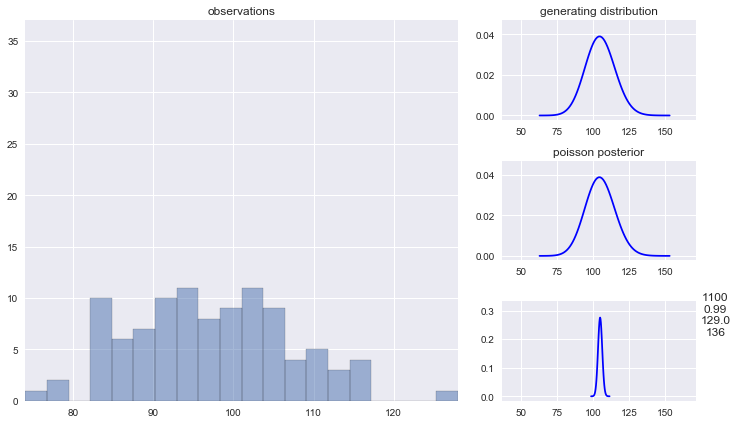

In [28]:
from IPython.display import HTML
ani = utils.visualize_online_learning(
    observations,
    predictions,
    model_params,
    true_dists,
    confidence=CONFIDENCE,
    bins=20,
    last_n=100)
HTML(ani.to_html5_video())